# Twin4Build: Neural policy control example

Welcome to this tutorial on using the Twin4Build package! In this notebook, you'll learn how to:
1. Create a simple t4b model
2. Define a neural network policy
3. Modify the model to incorporate the policy as a controller
4. Run a simulation with the neural policy controller

Let's get started!

## 1. Setup
First, let's install and import the necessary packages:

In [1]:
#%pip install git+https://github.com/JBjoernskov/Twin4Build.git # Uncomment in google colab
import sys
import twin4build as tb
import datetime
from dateutil import tz
import twin4build.utils.plot.plot as plot

## 2. Creating the Model

In this example, we will use the one_room_example_model.xlsm file. 
This file contains a model of a single room with a space heater and supply and return ventilation.
We use the translation engine to automatically create the components and connections.

In [2]:
import twin4build.examples.utils as utils
# Create a new model
model = tb.Model(id="mymodel")
filename = utils.get_path(["parameter_estimation_example", "one_room_example_model.xlsm"])
model.load(semantic_model_filename=filename)


c:\project\t4b_fork\twin4build\twin4build\utils\mkdir_in_root.py:5: MainPathNotFound: Could not determine main module path, using temp dir: C:\Users\asces\AppData\Local\Temp
  current_dir = get_main_dir()



Loading model...
   |___Reading semantic model...[OK]
   |___Drawing input object graph...[OK]
   |___Parsing semantic model...[OK]
   |___Drawing parsed object graph...[OK]
   |___Connecting components...[OK]
   |___Drawing system graph...[OK]
   |___Removing cycles...[OK]
   |___Drawing system graph without cycles...[OK]
   |___Determining execution order...[OK]
   |___Creating execution graph...[OK]
   |___Drawing execution graph...[OK]
   |___Loading parameters...[OK]
   |___Validating model...[WARNING]
   |   |
   |   |___|CLASS: BuildingSpace0AdjBoundaryOutdoorFMUSystem|ID: [020B][020B_space_heater]|: Missing values for the following parameter(s) to enable use of Simulator, Evaluator, and Monitor:
   |   |   |
   |   |   |___C_supply
   |   |   |___C_wall
   |   |   |___C_air
   |   |   |___C_boundary
   |   |   |___R_out
   |   |   |___R_in
   |   |   |___R_boundary
   |   |   |___f_wall
   |   |   |___f_air
   |   |   |___Q_occ_gain
   |   |   |___CO2_occ_gain
   |   |   |___C

From the model validation above we see that different types of information is missing. 
As we are focusing on parameter estimation in this example, we will add the missing information that is relevant to this task.
Here, the "[020B][020B_space_heater]" component is missing an input "supplyWaterTemperature".
In addition, some filenames are missing for the sensors and some of the schedules need to be defined.
Let's add the missing information and validate again.


In [3]:
def fcn(self):
    supply_water_schedule = tb.ScheduleSystem(
    weekDayRulesetDict = {
        "ruleset_default_value": 60,
        "ruleset_start_minute": [],
        "ruleset_end_minute": [],
        "ruleset_start_hour": [],
        "ruleset_end_hour": [],
        "ruleset_value": []
    },
    id="supply_water_schedule"
    )
    self.add_connection(supply_water_schedule, self.component_dict["[020B][020B_space_heater]"], "scheduleValue", "supplyWaterTemperature") # Add missing input
    self.component_dict["020B_temperature_sensor"].filename = utils.get_path(["parameter_estimation_example", "temperature_sensor.csv"])
    self.component_dict["020B_co2_sensor"].filename = utils.get_path(["parameter_estimation_example", "co2_sensor.csv"])
    self.component_dict["020B_valve_position_sensor"].filename = utils.get_path(["parameter_estimation_example", "valve_position_sensor.csv"])
    self.component_dict["020B_damper_position_sensor"].filename = utils.get_path(["parameter_estimation_example", "damper_position_sensor.csv"])
    self.component_dict["BTA004"].filename = utils.get_path(["parameter_estimation_example", "supply_air_temperature.csv"])
    self.component_dict["020B_co2_setpoint"].weekDayRulesetDict = {"ruleset_default_value": 900,
                                                                    "ruleset_start_minute": [],
                                                                    "ruleset_end_minute": [],
                                                                    "ruleset_start_hour": [],
                                                                    "ruleset_end_hour": [],
                                                                    "ruleset_value": []}
    self.component_dict["020B_temperature_heating_setpoint"].useFile = True
    self.component_dict["020B_temperature_heating_setpoint"].filename = utils.get_path(["parameter_estimation_example", "temperature_heating_setpoint.csv"])
    self.component_dict["outdoor_environment"].filename = utils.get_path(["parameter_estimation_example", "outdoor_environment.csv"])


model.load(semantic_model_filename=filename, fcn=fcn, verbose=False)


Loading model...
   |___Reading semantic model...[OK]
   |___Drawing input object graph...[OK]
   |___Parsing semantic model...[OK]
   |___Drawing parsed object graph...[OK]
   |___Connecting components...[OK]
   |___Applying user defined function...[OK]
   |___Drawing system graph...[OK]
   |___Removing cycles...[OK]
   |___Drawing system graph without cycles...[OK]
   |___Determining execution order...[OK]
   |___Creating execution graph...[OK]
   |___Drawing execution graph...[OK]
   |___Loading parameters...[OK]
   |___Validating model...[WARNING]
   |   |
   |   |___|CLASS: BuildingSpace0AdjBoundaryOutdoorFMUSystem|ID: [020B][020B_space_heater]|: Missing values for the following parameter(s) to enable use of Simulator, Evaluator, and Monitor:
   |   |   |
   |   |   |___C_supply
   |   |   |___C_wall
   |   |   |___C_air
   |   |   |___C_boundary
   |   |   |___R_out
   |   |   |___R_in
   |   |   |___R_boundary
   |   |   |___f_wall
   |   |   |___f_air
   |   |   |___Q_occ_gain

As shown above, the validation of the model for Estimation now passes.

### Visualizing the Model (not required)
We can visualize the model to see the components and connections.<br>
This is not required, but it can be helpful for debugging and for building the model.<br>
The nodes in the graph represent components, and the edges represent connections between components as defined earlier.

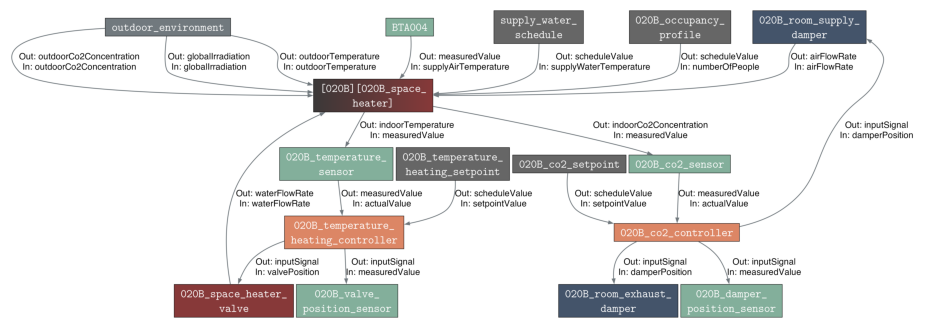

In [4]:
import matplotlib.pyplot as plt
import os
system_graph = os.path.join(model.graph_path, "system_graph.png")
image = plt.imread(system_graph)
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.axis('off')
plt.show()

## 3. Incorporating the neural policy controller

Now that our model is set up, let's define a control strategy that might benefit from using a neural policy instead of classic controllers. The inputs of the policy could be:
- Outdoor temperature
- Supply air temperature
- Supply water temperature
- Space heater valve position
- Room supply damper position (In this case, supply and damper position are the same, so one signal provides enough information)
- Room CO2 level

The outputs would be:

- Temperature heating setpoint
- CO2 setpoint

We will use a policy previously trained with Reinforcement Learning to reduce energy usage in this model.


## Visualizing the Results

Finally, let's visualize the results of our simulation.

In [ ]:
from dateutil.tz import gettz 
stepSize = 600  # Seconds
startTime = datetime.datetime(year=2023, month=11, day=27, hour=0, minute=0, second=0,
                                tzinfo=gettz("Europe/Copenhagen"))
endTime = datetime.datetime(year=2023, month=12, day=7, hour=0, minute=0, second=0,
                            tzinfo=gettz("Europe/Copenhagen"))
